<h3 style="text-align: center; font-style: italic;"> Exploring Quantum-Resistant Signatures for Ethereum’s Hybrid Blockchain</h3>
<h1 style="text-align: center; font-weight: bold"> Proof-of-concept Implementation </h1>

---

## **IMPORTS**

In [1]:
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import pandas as pd

from tqdm import tqdm

from blockchain.blockchain import Blockchain, Validator
from blockchain.pow_blockchain import PoWBlockchain
from signature_schemes.ecdsa_scheme import ECDSASignatureScheme
from signature_schemes.mldsa_scheme import MLDSASignatureScheme
from transactions.transaction import Transaction
from hashlib import sha256, sha512

sns.set(context='notebook', font='Serif')

In [2]:
# Utility functions for time measurement

def measure_sign_time(scheme, sk, message):
    start = time.perf_counter()
    sig = scheme.sign(sk, message)
    return sig, time.perf_counter() - start

def measure_verify_time(scheme, pk, message, sig):
    start = time.perf_counter()
    result = scheme.verify(pk, message, sig)
    return result, time.perf_counter() - start

def block_metrics_summary(blockchain):
    return pd.DataFrame(blockchain.summary())

def estimate_gas(signature: bytes) -> int:
    """
    Estimates Ethereum calldata gas cost for a given signature.
    Assumes: 16 gas per non-zero byte, 4 gas per zero byte.
    """
    return sum(16 if b != 0 else 4 for b in signature)


## **Experimental Setup**
---

In [3]:
# Set up phase parameters
NUM_BLOCKS = 1000
ECDSA_RATIO_CASES = {
    "Phase 1 (100% ECDSA - 0% ML-DSA )": 1.0,
    "Phase 2 (75% ECDSA - 25% ML-DSA)": 0.75,
    "Phase 3 (25% ECDSA - 75% ML-DSA)": 0.25,
    "Phase 4 (0% ECDSA - 100% ML-DSA)": 0.0
}

## **Block Time Measurements**
---
*This section measures the time take to create a block and add it to the differnt chains, the block time is averaged over 1 000 blocks.*

In [4]:
# Run Block time measurements for different Phases

ecdsa = ECDSASignatureScheme()
mldsa = MLDSASignatureScheme()

validators = [Validator(f"V{i}", ecdsa, mldsa) for i in range(5)]

results = {}

for label, ratio in ECDSA_RATIO_CASES.items():
    chain = Blockchain(validators, ecdsa_ratio=ratio)
    times = []

    for i in tqdm(range(NUM_BLOCKS), desc=f"Running {label} block time measurements", bar_format='{desc}: {bar:30} {percentage:3.0f}%'):
        txs = [Transaction("Alice", "Bob", i)]
        start = time.perf_counter()
        chain.add_block(txs)
        times.append(time.perf_counter() - start)

    df = block_metrics_summary(chain)
    df = df[df["index"] != 0].reset_index(drop=True)
    df["block_time"] = times
    df["case"] = label
    results[label] = df


Running Phase 1 (100% ECDSA - 0% ML-DSA ) block time measurements: ██████████████████████████████ 100%
Running Phase 2 (75% ECDSA - 25% ML-DSA) block time measurements: ██████████████████████████████ 100%
Running Phase 3 (25% ECDSA - 75% ML-DSA) block time measurements: ██████████████████████████████ 100%
Running Phase 4 (0% ECDSA - 100% ML-DSA) block time measurements: ██████████████████████████████ 100%


In [5]:
# Run PoW block time measurments 
difficulty_level = 3
pqc_pow_chain = PoWBlockchain(difficulty = difficulty_level, block_hash_function = sha512, tx_scheme=MLDSASignatureScheme())
pqc_pow_times = []
non_pqc_pow_chain = PoWBlockchain(difficulty= difficulty_level, block_hash_function = sha256, tx_scheme=ECDSASignatureScheme()) 
non_pqc_pow_times = []

for i in tqdm(range(NUM_BLOCKS), desc=f"Running Quantum Resistant PoW simulation with difficulty level {difficulty_level} :",bar_format='{desc}: {bar:30} {percentage:3.0f}%') :
    start = time.perf_counter()
    pqc_pow_chain.add_block([Transaction("Alice", "Bob", i)])
    pqc_pow_times.append(time.perf_counter() - start)

df_pqc_pow = block_metrics_summary(pqc_pow_chain)
df_pqc_pow = df_pqc_pow[df_pqc_pow["index"] != 0].reset_index(drop=True)
df_pqc_pow["block_time"] = pqc_pow_times
df_pqc_pow["case"] = "Quantum Resistant PoW"
results["PoW"] = df_pqc_pow


for i in tqdm(range(NUM_BLOCKS), desc=f"Running Non-Quantum Resistant PoW simulation with difficulty level {difficulty_level} ",bar_format='{desc}: {bar:30} {percentage:3.0f}%') :
    start = time.perf_counter()
    non_pqc_pow_chain.add_block([Transaction("Alice", "Bob", i)])
    non_pqc_pow_times.append(time.perf_counter() - start)

df_non_pqc_pow = block_metrics_summary(non_pqc_pow_chain)
df_non_pqc_pow = df_non_pqc_pow[df_non_pqc_pow["index"] != 0].reset_index(drop=True)
df_non_pqc_pow["block_time"] = non_pqc_pow_times
df_non_pqc_pow["case"] = "Non-Quantum Resistant PoW"
results["Non-PoW"] = df_non_pqc_pow


Running Quantum Resistant PoW simulation with difficulty level 3 :: ██████████████████████████████ 100%
Running Non-Quantum Resistant PoW simulation with difficulty level 3 : ██████████████████████████████ 100%


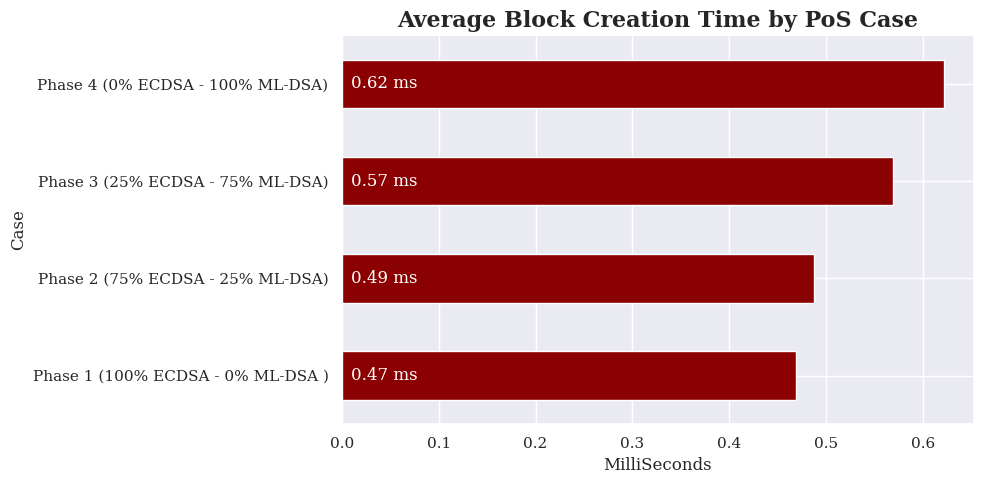

In [6]:
# Plot average block time of Phases only
results_no_pow = {k: v for k, v in results.items() if "PoW" not in k}
all_results = pd.concat(results.values(), ignore_index=True)
all_results_no_pow = pd.concat(results_no_pow.values(), ignore_index=True)


plt.figure(figsize=(10, 5))
plt.title("Average Block Creation Time by PoS Case", fontsize=16, fontweight='bold')

# Calculate average block time for each case in milliseconds
all_results_no_pow["block_time"] = all_results_no_pow["block_time"] * 1000  # Convert to milliseconds
avg_times = all_results_no_pow.groupby("case")["block_time"].mean().sort_values()
avg_times.plot(kind="barh", color = "darkred")

# Set labels
for i, v in enumerate(avg_times):
    
    plt.text(0.01, i, f"{v:.2f} ms", color='white', va='center')


plt.xlabel("MilliSeconds")
# plt.xscale('log')
plt.ylabel("Case")
plt.tight_layout()
plt.show()

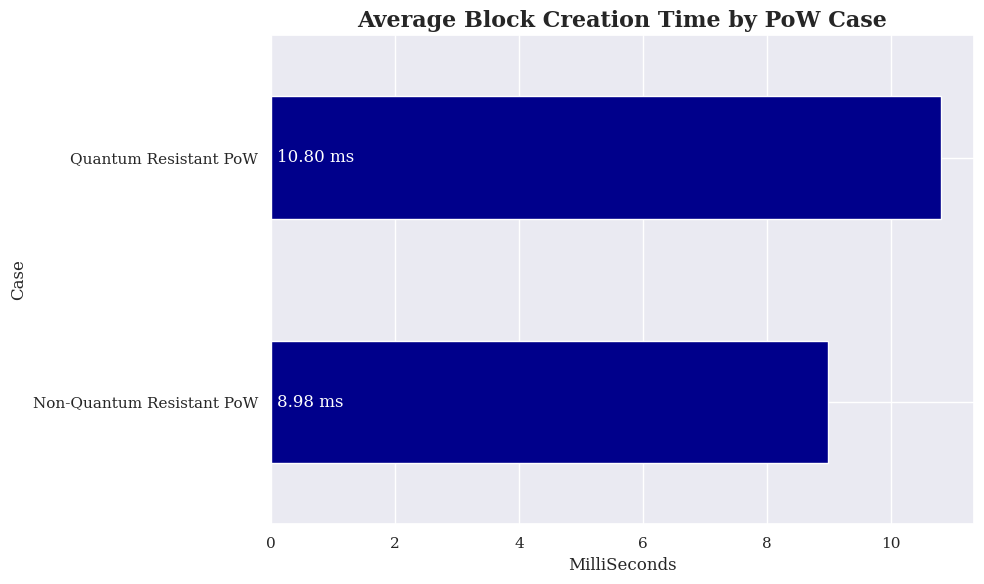

In [7]:
# Plot average block time of PoW cases only
plt.figure(figsize=(10, 6))
plt.title("Average Block Creation Time by PoW Case", fontsize=16, fontweight='bold')

# Calculate average block time for each case in milliseconds
pow_results = {k: v for k, v in results.items() if "PoW" in k}
pow_results_df = pd.concat(pow_results.values(), ignore_index=True)
pow_results_df["block_time"] = pow_results_df["block_time"] * 1000  # Convert to milliseconds
avg_pow_times = pow_results_df.groupby("case")["block_time"].mean().sort_values()
avg_pow_times.plot(kind="barh", color = "darkblue")

# Set labels
for i, v in enumerate(avg_pow_times):
    plt.text(0.1, i, f"{v:.2f} ms", color='white', va='center')

plt.xlabel("MilliSeconds")
plt.ylabel("Case")
plt.tight_layout()
plt.show()

## **Measuring Singing and Veryifcation Times for the different ETHEREUM phases**
---
*This section measure the times taken to sign and verify a transaction in the different phases of the Ethereum blockchain. The times are averaged over 1 000 transactions.*

In [8]:
# Compare signature sizes

sk_ecdsa, pk_ecdsa = ecdsa.generate_keys()
sk_mldsa, pk_mldsa = mldsa.generate_keys()


sig_ecdsa = ecdsa.sign(sk_ecdsa, "msg")
sig_mldsa = mldsa.sign(sk_mldsa, "msg")


pd.DataFrame({
    "Scheme": ["ECDSA", "ML-DSA"],
    "Signature Size (bytes)": [len(sig_ecdsa), len(sig_mldsa)]
})


,Scheme,Signature Size (bytes)
0,ECDSA,64
1,ML-DSA,3309


In [9]:
# Runing signing and verification time measurements

sign_results = []
verify_results = []

# Reuse keypairs per scheme
ecdsa = ECDSASignatureScheme()
mldsa = MLDSASignatureScheme()
sk_ecdsa, pk_ecdsa = ecdsa.generate_keys()
sk_mldsa, pk_mldsa = mldsa.generate_keys()
msg = "Benchmark test message"

# Get raw signatures for both schemes
sig_ecdsa = ecdsa.sign(sk_ecdsa, msg)
sig_mldsa = mldsa.sign(sk_mldsa, msg)

# Store signature sizes and gas costs
signature_profiles = {
    "ecdsa": {
        "size": len(sig_ecdsa),
        "gas": estimate_gas(sig_ecdsa)
    },
    "mldsa": {
        "size": len(sig_mldsa),
        "gas": estimate_gas(sig_mldsa)
    }
}


# Per phase
for label, ratio in ECDSA_RATIO_CASES.items():
    # Repeat measurements
    ecdsa_sign_times = []
    mldsa_sign_times = []
    ecdsa_verify_times = []
    mldsa_verify_times = []

    for _ in tqdm(range(NUM_BLOCKS), desc=f"Running {label} singing and verification measurements", bar_format='{desc}: {bar:30} {percentage:3.0f}%'):
        # Measure signing and verification times
        sig_e, t_e = measure_sign_time(ecdsa, sk_ecdsa, msg)
        ecdsa_sign_times.append(t_e)
        _, v_e = measure_verify_time(ecdsa, pk_ecdsa, msg, sig_e)
        ecdsa_verify_times.append(v_e)

        sig_m, t_m = measure_sign_time(mldsa, sk_mldsa, msg)
        mldsa_sign_times.append(t_m)
        _, v_m = measure_verify_time(mldsa, pk_mldsa, msg, sig_m)
        mldsa_verify_times.append(v_m)

    # Weighted average based on phase ratio
    sign_avg = ratio * sum(ecdsa_sign_times)/len(ecdsa_sign_times) + \
               (1 - ratio) * sum(mldsa_sign_times)/len(mldsa_sign_times)

    verify_avg = ratio * sum(ecdsa_verify_times)/len(ecdsa_verify_times) + \
                 (1 - ratio) * sum(mldsa_verify_times)/len(mldsa_verify_times)

    # Store results
    sign_results.append({"phase": label, "avg_sign_time": sign_avg})
    verify_results.append({"phase": label, "avg_verify_time": verify_avg})

# Append signature size and gas estimates to each phase
for entry in sign_results:
    phase = entry["phase"]
    ratio = ECDSA_RATIO_CASES[phase]
    
    # Weighted signature size and gas
    sig_size = ratio * signature_profiles["ecdsa"]["size"] + (1 - ratio) * signature_profiles["mldsa"]["size"]
    gas_cost = ratio * signature_profiles["ecdsa"]["gas"] + (1 - ratio) * signature_profiles["mldsa"]["gas"]

    entry["avg_signature_size"] = sig_size
    entry["est_gas_cost"] = gas_cost



Running Phase 1 (100% ECDSA - 0% ML-DSA ) singing and verification measurements:                                  0%

Running Phase 1 (100% ECDSA - 0% ML-DSA ) singing and verification measurements: ██████████████████████████████ 100%
Running Phase 2 (75% ECDSA - 25% ML-DSA) singing and verification measurements: ██████████████████████████████ 100%
Running Phase 3 (25% ECDSA - 75% ML-DSA) singing and verification measurements: ██████████████████████████████ 100%
Running Phase 4 (0% ECDSA - 100% ML-DSA) singing and verification measurements: ██████████████████████████████ 100%


In [10]:
# Display average signature size and gas estimates

sign_df = pd.DataFrame(sign_results)
sign_df[["phase", "avg_signature_size", "est_gas_cost"]]

,phase,avg_signature_size,est_gas_cost
0,Phase 1 (100% ECDSA - 0% ML-DSA ),64.00,1024.0
1,Phase 2 (75% ECDSA - 25% ML-DSA),875.25,13914.0
2,Phase 3 (25% ECDSA - 75% ML-DSA),2497.75,39694.0
3,Phase 4 (0% ECDSA - 100% ML-DSA),3309.00,52584.0


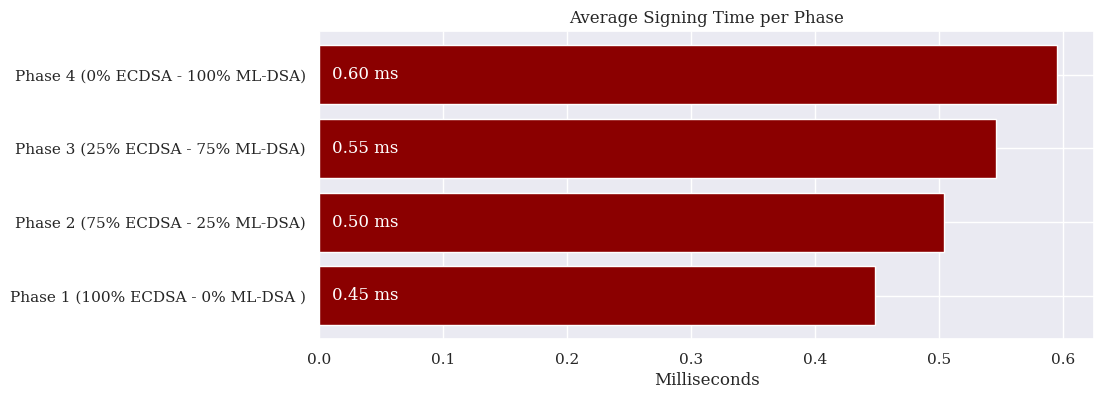

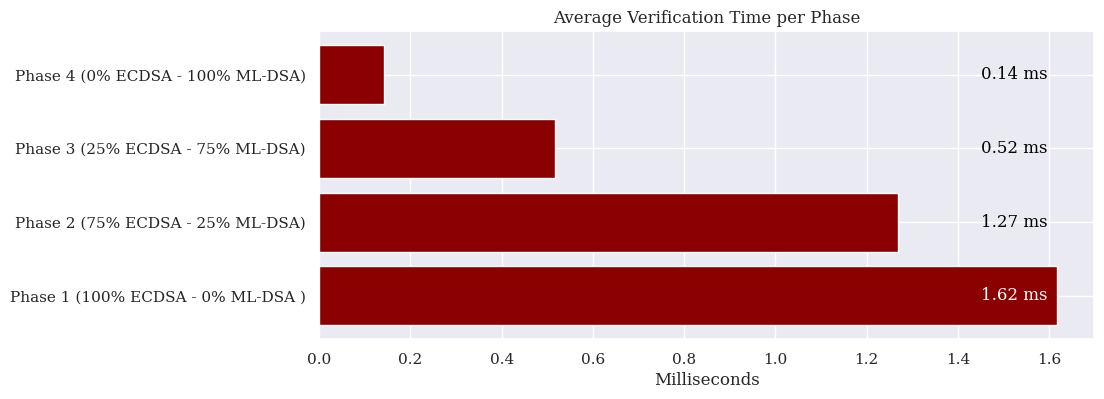

In [11]:
# Plot average signing and verification times per phase
# Convert to DataFrame
sign_df = pd.DataFrame(sign_results) 
sign_df["avg_sign_time"] = sign_df["avg_sign_time"] * 1000  # Convert to milliseconds
verify_df = pd.DataFrame(verify_results)
verify_df["avg_verify_time"] = verify_df["avg_verify_time"] * 1000  # Convert to milliseconds

plt.figure(figsize=(10, 4))
plt.barh(sign_df["phase"], sign_df["avg_sign_time"], color="darkred")
# Set labels
for i, v in enumerate(sign_df["avg_sign_time"]):
    plt.text(0.01, i, f"{v:.2f} ms", color='white', va='center')
plt.xlabel("Milliseconds")
# plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter("%.2e"))
plt.title("Average Signing Time per Phase")
plt.show()

plt.figure(figsize=(10, 4))
plt.barh(verify_df["phase"], verify_df["avg_verify_time"], color="darkred")
# Set labels
for i, v in enumerate(verify_df["avg_verify_time"]):
    if v < 1.40:
        plt.text(1.45, i, f"{v:.2f} ms", color='black', va='center')
    else:
        plt.text(1.45, i, f"{v:.2f} ms", color='white', va='center')
    
plt.xlabel("Milliseconds")
# plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter("%.4f"))
plt.title("Average Verification Time per Phase")
plt.show()


## **Final Summary**
---

In [12]:
# Final Summary table with block times, signing and verification times
phases_summary = all_results.groupby("case").agg({
    "block_time": "mean"
}).rename(columns={"block_time": "Avg Block Time (s)"})

# Only include phases for which timing data is available (i.e., exclude PoW)
phases_with_timing = set(sign_df["phase"]) & set(phases_summary.index)

phases_summary["Avg Sign Time (mS)"] = [
    sign_df.set_index("phase").loc[c, "avg_sign_time"] if c in phases_with_timing else None
    for c in phases_summary.index
]

phases_summary["Avg Sign Time (mS)"] = phases_summary["Avg Sign Time (mS)"] 

phases_summary["Avg Verify Time (mS)"] = [
    verify_df.set_index("phase").loc[c, "avg_verify_time"] if c in phases_with_timing else None
    for c in phases_summary.index
]
phases_summary["Avg Verify Time (mS)"] = phases_summary["Avg Verify Time (mS)"] 

phases_summary["Weighted Avg Sig Size (bytes)"] = [
    sign_df.set_index("phase").loc[c, "avg_signature_size"] if c in phases_with_timing else None
    for c in phases_summary.index
]
phases_summary["Est. Gas Cost (calldata)"] = [
    sign_df.set_index("phase").loc[c, "est_gas_cost"] if c in phases_with_timing else None
    for c in phases_summary.index
]

# Replace NaN with "N/A" for better readability
phases_summary = phases_summary.fillna("N/A")

# Sort the summary by average block time
phases_summary = phases_summary.sort_values(by="Avg Block Time (s)", ascending=True)


phases_summary

,Avg Block Time (s),Avg Sign Time (mS),Avg Verify Time (mS),Weighted Avg Sig Size (bytes),Est. Gas Cost (calldata)
case,,,,,
Phase 1 (100% ECDSA - 0% ML-DSA ),0.000469,0.448119,1.618047,64.0,1024.0
Phase 2 (75% ECDSA - 25% ML-DSA),0.000487,0.503842,1.269588,875.25,13914.0
Phase 3 (25% ECDSA - 75% ML-DSA),0.000569,0.545591,0.51599,2497.75,39694.0
Phase 4 (0% ECDSA - 100% ML-DSA),0.000622,0.595097,0.142134,3309.0,52584.0
Non-Quantum Resistant PoW,0.008981,N/A,N/A,N/A,N/A
Quantum Resistant PoW,0.010802,N/A,N/A,N/A,N/A


---
*Dany A. Darghohuth - June 2025*